## Practice Pulling Data from Sloan Digital Sky Survey (Specific Position Regions) ##

In [1]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords

# Define the target position (RA, Dec) in degrees
target_position = coords.SkyCoord(ra=150, dec=2.0, unit='deg', frame='icrs')

# Query SDSS for photometric data
result = SDSS.query_region(target_position, radius='2.5 arcmin', photoobj_fields=['ra', 'dec', 'u', 'g', 'r', 'i', 'z'])

# Display the results
print(result)

       objID               ra              dec        ...    i        z    
------------------- ---------------- ---------------- ... -------- --------
1237651736280695060 150.023624228974 1.98308407457287 ... 20.23153 20.16952
1237653664721993906 150.023624473467 1.98307176930408 ... 20.06032 20.28649
1237651736280695589 150.027814149003 1.97759375068481 ... 21.30561 20.10799
1237651736280761147 150.027815971412 1.97758393121166 ...  -9999.0  -9999.0
1237653664721994648 150.027860559061 1.97762120675163 ... 21.60671 21.68682
1237651736280695469 150.003843593927 1.96947674466095 ...  21.1775 20.48815
1237653664721994548 150.003923534572 1.96945891345637 ... 20.66825 20.00115
1237651736280695475 150.016255389114 1.98372022762677 ...  19.8926 19.08648
1237653664721994553 150.016261752259  1.9837120467736 ... 19.99393 19.37196
1237651736280694976 150.012329161957 1.96169474387217 ... 16.75584 16.27265
                ...              ...              ... ...      ...      ...
123765173628

## Color Color Diagram of Sample Results Pulled from SDSS ##

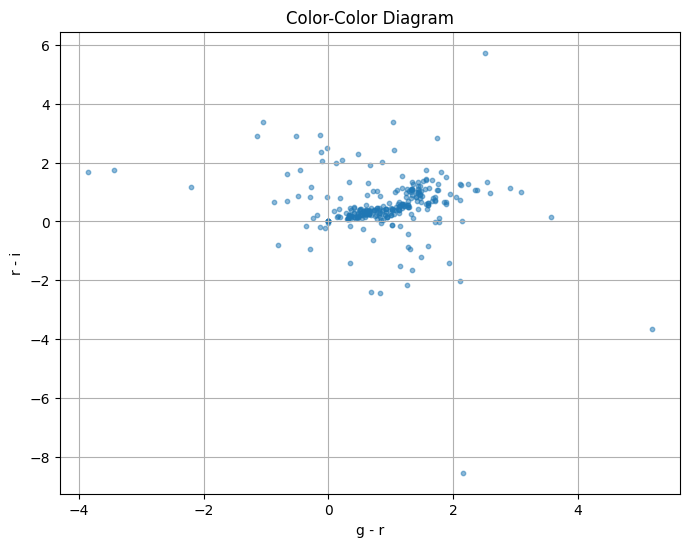

In [2]:
import matplotlib.pyplot as plt

# Calculate color indices
g_r = result['g'] - result['r']
r_i = result['r'] - result['i']

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(g_r, r_i, alpha=0.5, s=10)
plt.xlabel('g - r')
plt.ylabel('r - i')
plt.title('Color-Color Diagram')
plt.grid()
plt.show()

## Sky Map of Data Pulled from SDSS ##

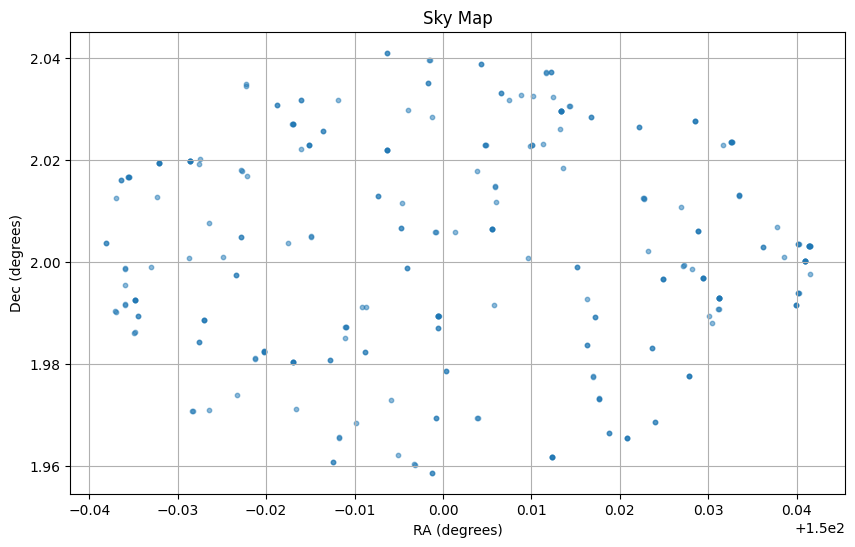

In [3]:
plt.figure(figsize=(10, 6))
plt.scatter(result['ra'], result['dec'], alpha=0.5, s=10)
plt.xlabel('RA (degrees)')
plt.ylabel('Dec (degrees)')
plt.title('Sky Map')
plt.grid()
plt.show()

# Hubble Diagram, Uncertainty, and Reproduction Work #

Purpose is to reproduce Fig. 8 from:

$\text{Betoule, M., et al. (2014). \textit{Improved cosmological constraints from a joint analysis of the SDSS-II and SNLS supernova samples}. Astronomy \& Astrophysics, 568, A22. DOI: [10.1051/0004-6361/201423413]}$


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import pandas as pd
from scipy.integrate import quad

## Hubble Diagram - Raw Data ##

Data Source: https://github.com/cmbant/CosmoMC/blob/master/data/jla_lcparams.txt

    #name      zcmb    zhel   dz         mb       dmb        x1       dx1  \
0  03D1au  0.503084  0.5043  0.0  23.001698  0.088031  1.273191  0.150058   
1  03D1aw  0.580724  0.5820  0.0  23.573937  0.090132  0.974346  0.273823   
2  03D1ax  0.494795  0.4960  0.0  22.960139  0.088110 -0.728837  0.102069   
3  03D1bp  0.345928  0.3470  0.0  22.398137  0.087263 -1.155110  0.112834   
4  03D1co  0.677662  0.6790  0.0  24.078115  0.098356  0.618820  0.404295   

      color    dcolor  3rdvar  d3rdvar   cov_m_s   cov_m_c   cov_s_c  set  
0 -0.012353  0.030011   9.517   0.1105  0.000790  0.000440 -0.000030    1  
1 -0.025076  0.036691   9.169   0.0880  0.002823  0.000415  0.001574    1  
2 -0.099683  0.030305  11.580   0.1125  0.000542  0.000475 -0.000024    1  
3 -0.040581  0.026679  10.821   0.1235  0.001114  0.000616  0.000295    1  
4 -0.039380  0.067403   8.647   0.2840  0.011857  0.000780  0.005898    1  


/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_10731/3735326465.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv('jla_lcparams.txt', delim_whitespace=True)


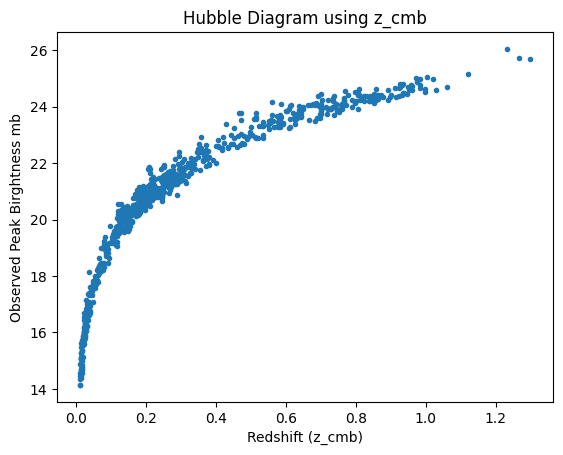

In [5]:
# Load data from jla_lcparams.txt
data = pd.read_csv('jla_lcparams.txt', delim_whitespace=True)
# Display the first few rows to inspect the data
print(data.head())

# Extract zcmb
z = data['zcmb']
mb = data['mb']

# Plot
plt.plot(z, mb, 'o', markersize=3)
plt.xlabel('Redshift (z_cmb)')
plt.ylabel('Observed Peak Birghtness mb')
plt.title('Hubble Diagram using z_cmb')
plt.show()

## Hubble Diagram with Log scaled x-axis and and color coded for Survey Source ##

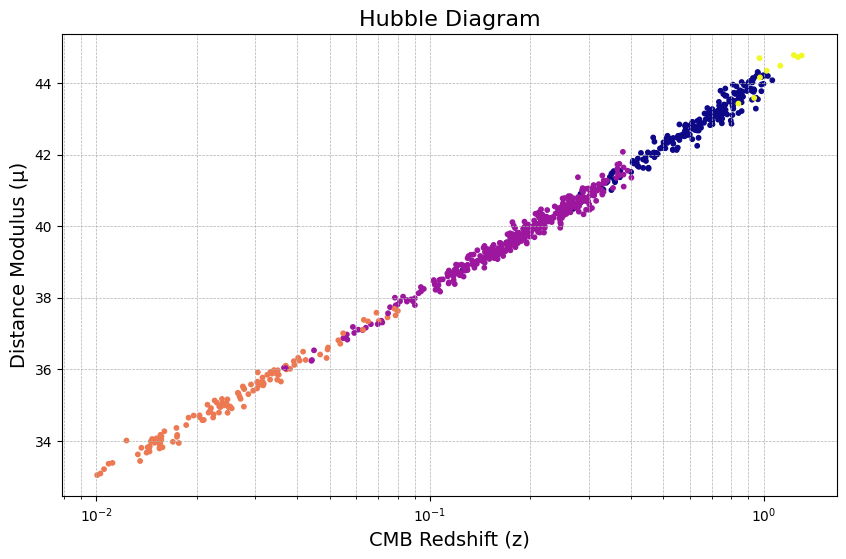

In [6]:
# Data extracted from jla_lcparams.txt
zcmb = data['zcmb']  # Redshift (CMB frame)
mb = data['mb']      # Peak magnitude
x1 = data['x1']      # Stretch
color = data['color']  # Color parameter
set_values = data['set']  # Set values for color coding

# JLA (stat+sys) Parameters taken from 2014 Betoule artilce Table 10
alpha = 0.141
beta = 3.101
MB = -19.015

# Calculate distance modulus
mu = mb - MB + alpha * x1 - beta * color

# Plot the Hubble diagram
plt.figure(figsize=(10, 6))
scatter = plt.scatter(zcmb, mu, c=set_values, cmap='plasma', label='JLA Supernovae', s=10)
plt.xscale('log')  # Use a logarithmic scale for redshift
plt.xlabel('CMB Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus (μ)', fontsize=14)
plt.title('Hubble Diagram', fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

## Uncertainty Calculations ##

Error Propagation formula for: 

$ \mu = m_B^{*} - \left(M_B - \alpha \cdot X_1 + \beta \cdot C\right) $

is: 

$\sigma_{\mu}^2 = \sigma_{m_B^*}^2 + (\alpha \cdot \sigma_{X_1})^2 + (\beta \cdot \sigma_c)^2 + 2 \cdot \text{Cov}(m_B^*, X_1) \cdot \alpha + 2 \cdot \text{Cov}(m_B^*, C) \cdot \beta + 2 \cdot \text{Cov}(X_1, C) \cdot \alpha \cdot \beta$

Conceptual insight: covariance calcuations are necessary because one phenomena such as color or stretch influences other phenomena as well and thus must be accounted for in uncertainty propagation.

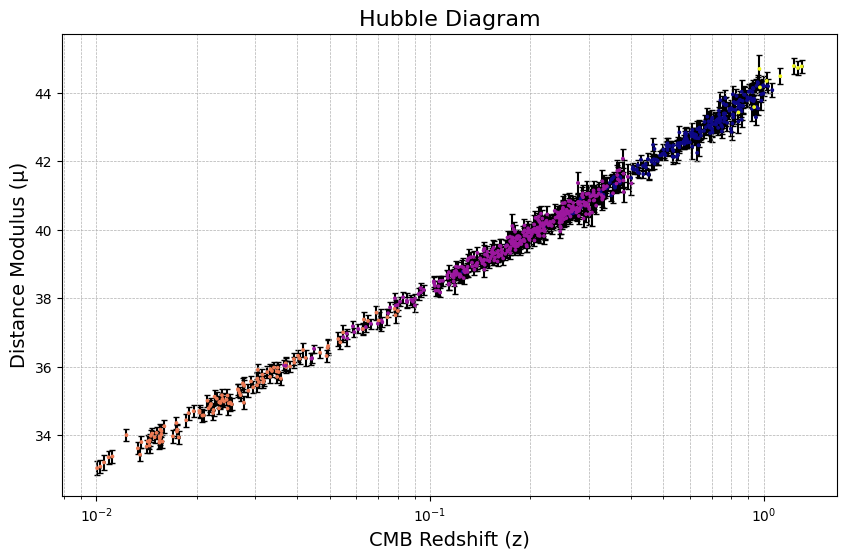

In [7]:
# uncertainties and covariances given in jla_lcparams.txt
dm_b = data['dmb']          # Uncertainty in m_B*
dx1 = data['dx1']           # Uncertainty in x1
dcolor = data['dcolor']     # Uncertainty in color
cov_m_s = data['cov_m_s']   # Covariance between m_B* and x1
cov_m_c = data['cov_m_c']   # Covariance between m_B* and color
cov_s_c = data['cov_s_c']   # Covariance between x1 and color

# Calculate uncertainty in distance modulus
sigma_mu = np.sqrt(
    dm_b**2 +
    (alpha * dx1)**2 +
    (beta * dcolor)**2 +
    2 * alpha * cov_m_s +
    2 * beta * cov_m_c +
    2 * alpha * beta * cov_s_c
)

# Plot the Hubble diagram with error bars
plt.figure(figsize=(10, 6))
plt.xscale('log')  # Use a logarithmic scale for redshift
plt.xlabel('CMB Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus (μ)', fontsize=14)
plt.title('Hubble Diagram', fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

# Scatter plot with error bars (single color)
plt.errorbar(
    zcmb, mu, yerr=sigma_mu, fmt='o', color='black', label='JLA Supernovae', capsize=2, markersize=1, zorder=1
)

#Scatter plot with color coding overlaid on same plot with error bars. 
scatter = plt.scatter(zcmb, mu, c=set_values, cmap='plasma', label='JLA Supernovae', s=3, zorder=2)

plt.show()


## Theoretical Fit ##

The luminosity distance $d_L$ in a flat universe where $\Omega_k = 0$ is given by:


$d_L(z) = \frac{c (1 + z)}{H_0} \int_0^z \frac{dz'}{\sqrt{\Omega_m (1 + z')^3 + \Omega_\Lambda}}$

Plugging this into the $\mu_{\Lambda-CDM}$ equation from Sect 6.1 of Betoule et. al. (2014):

$\mu_{\Lambda \text{CDM}}(z; \Omega_m) = 5 \log_{10}\left(\frac{d_L(z; \Omega_m)}{10 \, \text{pc}}\right)$

Final Formula: 

When $\Omega_\Lambda = 1 - \Omega_m$: 



$\mu_{\Lambda \text{CDM}}(z; \Omega_m) = 5 \log_{10}\left(\frac{\frac{c (1 + z)}{H_0} \int_0^z \frac{1}{\sqrt{\Omega_m (1 + z')^3 + 1 - \Omega_m}} dz' }{10 \, \text{pc}}\right)$



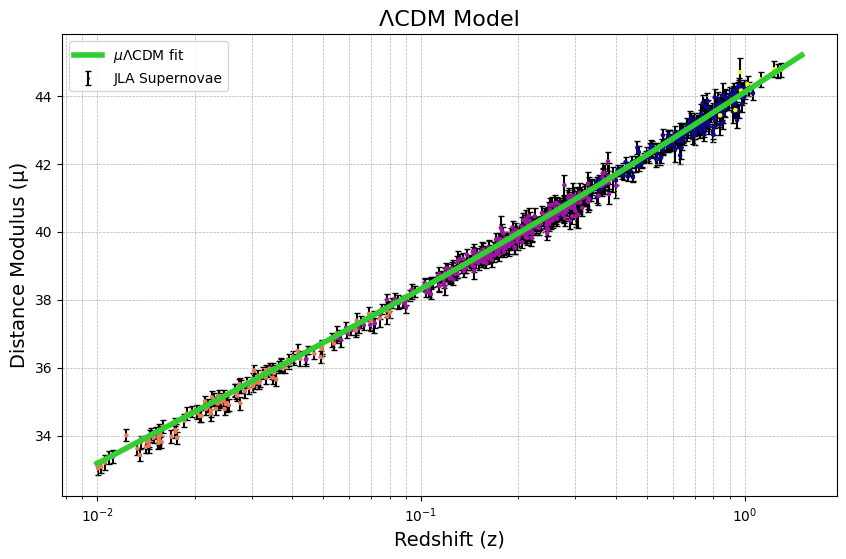

In [8]:
# Cosmological parameters
H_o = 70  # km / (s * Megaparsec) from M.Betoule 2014 Sect. 6.1
c = 3e5  # Speed of light in km/s 
Omega_m = 0.295 # From Table 10 M.Betoule 2014
Omega_Lambda = 1 - Omega_m

# Luminiosty distance function w/t integrand
# note: must define integrand as a function for the scipy quad function
def integrand(z_prime):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + Omega_Lambda)

def luminosity_distance(z):

    integral, absolute_error = quad(integrand, 0, z)
    
    d_L = (c / H_o) * (1 + z) * integral
    return d_L

# Calculate distance modulus for an input (sample) range of redshifts
z_vals = np.linspace(0.01, 1.5, 100)
d_L_vals = np.array([luminosity_distance(z) for z in z_vals])
mu_theoretical = 5 * np.log10(d_L_vals * 1e6 / 10) # H_o is in km/s/Mpc, d_L must convert to pc via 1e6

# Plot the theoretical curve on the Hubble diagram
plt.figure(figsize=(10, 6))

# Scatter plot with error bars
plt.errorbar(
    zcmb, mu, yerr=sigma_mu, fmt='o', color='black', label='JLA Supernovae', capsize=2, markersize=1, zorder=1
)

# Scatter plot
plt.scatter(zcmb, mu, c=set_values, cmap='plasma', s=5, zorder=2)

plt.plot(z_vals, mu_theoretical, color='#32CD32', label=r'$\mu \Lambda \text{CDM fit}$', linewidth=4, zorder=3)

plt.xscale('log')
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('Distance Modulus (μ)', fontsize=14)
plt.title('ΛCDM Model', fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.legend()
plt.show()

## Plotting the Residuals ##

<>:20: SyntaxWarning: invalid escape sequence '\m'
<>:20: SyntaxWarning: invalid escape sequence '\m'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_10731/1860180708.py:20: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$\mu$ - $\mu_{\Lambda CDM}$', fontsize=14)


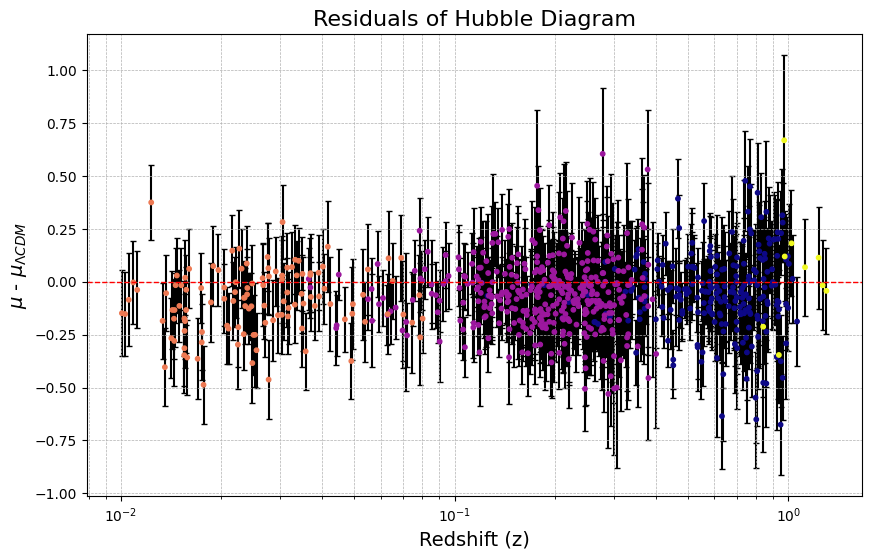

In [9]:
## NOTE: this is not same values as d_L_vals above. This is the d_L values for the zcmb values in the data set.

d_L_real_res_vals = np.array([luminosity_distance(z) for z in zcmb])

mu_theoretical = 5 * np.log10(d_L_real_res_vals * 1e6 / 10) # H_o is in km/s/Mpc, d_L must convert to pc via 1e6

plt.figure(figsize=(10, 6))

# Scatter plot with error bars
plt.errorbar(
    zcmb, mu - mu_theoretical, yerr=sigma_mu, fmt='o', color='black', label='JLA Supernovae', capsize=2, markersize=1, zorder=1
)

# Color Coded Scatter Plot with Error Bars
plt.xscale('log')
plt.scatter(zcmb, mu - mu_theoretical, c=set_values, cmap='plasma', s=10, zorder=2)

plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
plt.xlabel('Redshift (z)', fontsize=14)
plt.ylabel('$\mu$ - $\mu_{\Lambda CDM}$', fontsize=14)
plt.title('Residuals of Hubble Diagram', fontsize=16)
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

## Hubble Diagram Animation ##
An animation of the $\Lambda$-CMD model fit as $\Omega_m$ is varied from 0.01 to 1. 100 frames.
Commented out for the purposes of rerunning cod emost efficiently.

<>:49: SyntaxWarning: invalid escape sequence '\O'
<>:49: SyntaxWarning: invalid escape sequence '\O'
<>:49: SyntaxWarning: invalid escape sequence '\O'
<>:49: SyntaxWarning: invalid escape sequence '\O'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_18190/197215737.py:49: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title(f'Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}' + f' $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_18190/197215737.py:49: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title(f'Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}' + f' $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)


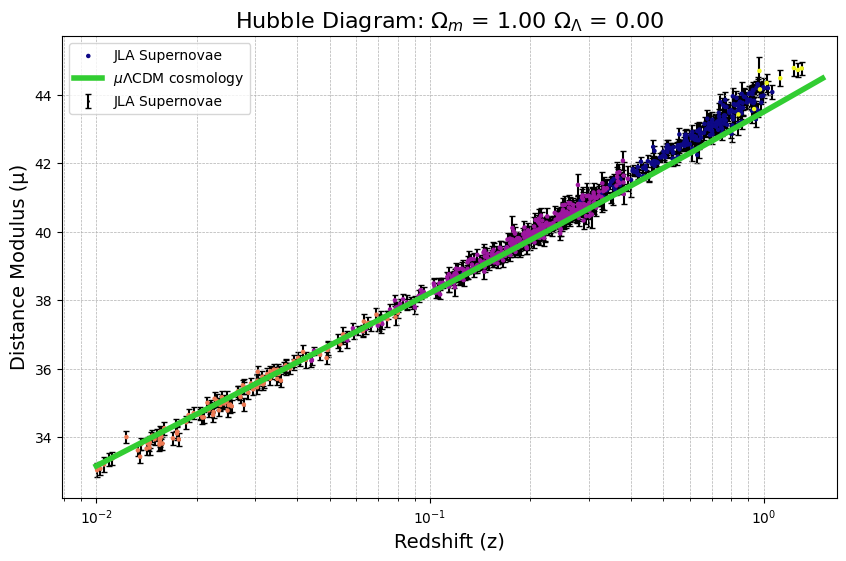

In [11]:
# # Define constants
# H_o = 70  # km / (s * Megaparsec)
# c = 3e5  # Speed of light in km/s
# Omega_m_values = np.linspace(0.01, 1, 100)  # Range of Omega_m values
# Omega_Lambda_values = np.linspace(1 - 0.01, 1 - 1, 100)


# # Integrand of luminosity distance function
# def integrand(z_prime, Omega_m):
#     return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))

# def luminosity_distance(z, Omega_m):
#     integral, _ = quad(integrand, 0, z, args=(Omega_m,))
#     d_L = (c / H_o) * (1 + z) * integral
#     return d_L

# # Create figure and axis
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_xscale('log')
# ax.set_xlabel('Redshift (z)', fontsize=14)
# ax.set_ylabel('Distance Modulus (μ)', fontsize=14)
# ax.set_title('Hubble Diagram for Varying Omega_m', fontsize=16)
# ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# # Scatter plot with error bars
# scatter = ax.errorbar(zcmb, mu, yerr=sigma_mu, fmt='o', color='black', label='JLA Supernovae', capsize=2, markersize=1, zorder=1)
# scatter = ax.scatter(zcmb, mu, c=set_values, cmap='plasma', label='JLA Supernovae', s=5, zorder=2)

# # Line plot for theoretical curve - initializes with no x or y data
# line, = ax.plot([], [], color='#32CD32', label=r'$\mu \Lambda \text{CDM cosmology}$', linewidth=4, zorder=3)


# legend = ax.legend()

# # Initialization function
# ## Resets the line data to an empty list and returns the line object as an empty touple. This required by the FuncAnimation function.
# def init():
#     line.set_data([], [])
#     return line,

# # Animation function
# def animate(i):
#     Omega_Lambda = Omega_Lambda_values[i]
#     Omega_m = Omega_m_values[i]
#     z_vals = np.linspace(0.01, 1.5, 100)
#     d_L_vals = np.array([luminosity_distance(z, Omega_m) for z in z_vals])
#     mu_theoretical = 5 * np.log10(d_L_vals * 1e6 / 10)  # H_o is in km/s/Mpc, d_L must convert to pc via 1e6
#     line.set_data(z_vals, mu_theoretical)
#     ax.set_title(f'Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}' + f' $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)
#     return line,

# # Create animation
# ani = FuncAnimation(fig, animate, init_func=init, frames=len(Omega_m_values), interval=100, blit=True)

# # Save the animation as a GIF
# ani.save('hubble_diagram_varying_both.gif', writer='pillow')

# plt.show()


# Marginalization of H_o #

### Definining a Gaussian Prior ###

$P(H_0) = \frac{1}{\sqrt{2\pi\sigma_{H_0}^2}} \exp\left(-\frac{(H_0 - \mu_{H_0})^2}{2\sigma_{H_0}^2}\right)$

where:
- $ H_0$ is the Hubble constant (in km/s/Mpc),
- $\mu_{H_0}$ is the mean of the prior, e.g.,$ \mu_{H_0} = 73.04 $
- $\sigma_{H_0} $ is the standard deviation of the prior, e.g., $\sigma_{H_0} = 1.04$


<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_10731/1612004986.py:11: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(H0_values, prior_values, label=f"Gaussian Prior ($\mu={mean}$, $\sigma={std}$)")
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_10731/1612004986.py:11: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(H0_values, prior_values, label=f"Gaussian Prior ($\mu={mean}$, $\sigma={std}$)")


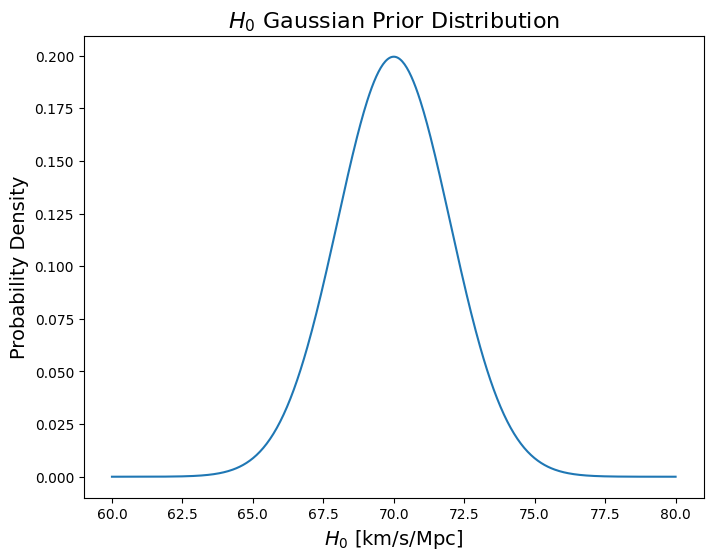

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Range of H0
H0_values = np.linspace(60, 80, 500)

prior_values = np.exp(-0.5 * ((H0_values - mean) / std)**2) / (std * np.sqrt(2 * np.pi))

# Plot the Gaussian prior
plt.figure(figsize=(8, 6))
plt.plot(H0_values, prior_values, label=f"Gaussian Prior ($\mu={mean}$, $\sigma={std}$)")
plt.title("$H_0$ Gaussian Prior Distribution", fontsize=16) 
plt.xlabel("$H_0$ [km/s/Mpc]", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.show()


### Defining a Likelyhood ###

$\mathcal{L}(H_0) = \exp\left(-\frac{1}{2} \frac{\left(\mu_{\text{obs}} - \mu_{\text{model}}\right)^2}{\sigma_\mu^2}\right)$

where:

- The observed distance modulus (taken from above calculations): $ \mu_{obs} = m_B^{*} - \left(M_B - \alpha \cdot X_1 + \beta \cdot C\right) $

- The modeled distance modulus (taken from above calculations): $\mu_{\Lambda \text{CDM}}(H_o; z) = 5 \log_{10}\left(\frac{\frac{c (1 + z)}{H_0} \int_0^z \frac{1}{\sqrt{\Omega_m (1 + z')^3 + 1 - \Omega_m}} dz' }{10 \, \text{pc}}\right)$


- The uncertainty in the observed distance modulus (taken from above calcuations): $\sigma_{\mu}^2 = \sigma_{m_B^*}^2 + (\alpha \cdot \sigma_{X_1})^2 + (\beta \cdot \sigma_c)^2 + 2 \cdot \text{Cov}(m_B^*, X_1) \cdot \alpha + 2 \cdot \text{Cov}(m_B^*, C) \cdot \beta + 2 \cdot \text{Cov}(X_1, C) \cdot \alpha \cdot \beta$


NOTE: Likelyhood is computed for each data point.



In [24]:
## We already have mu and mu_model. In our code its mu and mu_theoretical.
## We also already have sigma_mu through our error propagation calculations.
likelyhood = np.exp(-0.5 * ((mu - mu_theoretical) / sigma_mu)**2)


### Marginalizing over $H_o$ ###

## Trying somethign with Log Log Removed FROM BOTH THE SCALES AND STUFF ##

[4.31897324e+07 1.09435447e+08 1.77153716e+08 2.46320921e+08
 3.16913535e+08 3.88908141e+08 4.62281452e+08 5.37010330e+08
 6.13071802e+08 6.90443078e+08 7.69101565e+08 8.49024881e+08
 9.30190872e+08 1.01257762e+09 1.09616346e+09 1.18092698e+09
 1.26684704e+09 1.35390278e+09 1.44207364e+09 1.53133933e+09
 1.62167988e+09 1.71307560e+09 1.80550713e+09 1.89895542e+09
 1.99340174e+09 2.08882766e+09 2.18521509e+09 2.28254625e+09
 2.38080369e+09 2.47997029e+09 2.58002923e+09 2.68096402e+09
 2.78275850e+09 2.88539682e+09 2.98886344e+09 3.09314314e+09
 3.19822101e+09 3.30408245e+09 3.41071316e+09 3.51809914e+09
 3.62622668e+09 3.73508238e+09 3.84465312e+09 3.95492605e+09
 4.06588862e+09 4.17752854e+09 4.28983381e+09 4.40279267e+09
 4.51639364e+09 4.63062548e+09 4.74547722e+09 4.86093813e+09
 4.97699771e+09 5.09364570e+09 5.21087207e+09 5.32866705e+09
 5.44702103e+09 5.56592467e+09 5.68536882e+09 5.80534453e+09
 5.92584307e+09 6.04685590e+09 6.16837468e+09 6.29039123e+09
 6.41289760e+09 6.535885

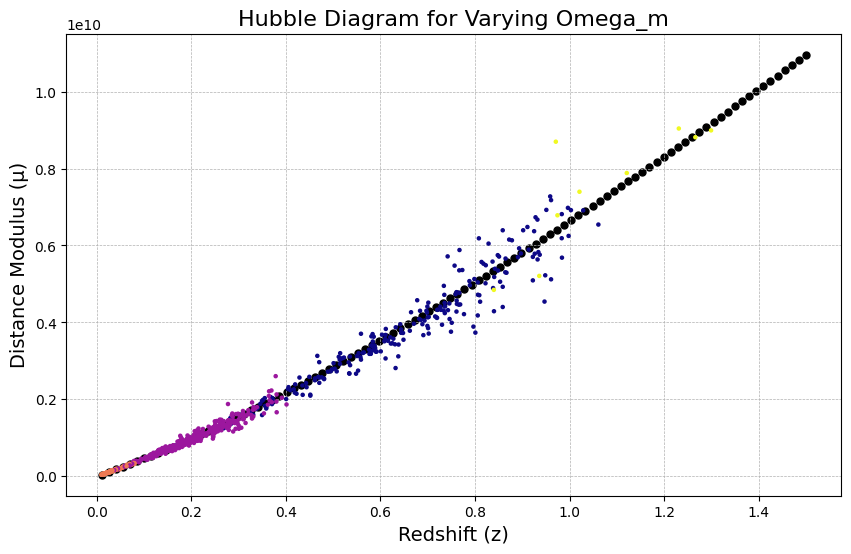

In [11]:
import numpy as np
from scipy.integrate import quad
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt

# Define constants
H_o = 70  # km / (s * Megaparsec)
c = 3e5  # Speed of light in km/s
Omega_m = 0.295 # From Table 10 M.Betoule 2014
Omega_Lambda = 1 - Omega_m


# Luminosity distance function
def integrand(z_prime, Omega_m):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + (1 - Omega_m))

def luminosity_distance(z, Omega_m):
    integral, _ = quad(integrand, 0, z, args=(Omega_m,))
    d_L = (c / H_o) * (1 + z) * integral
    return d_L

d_L_mykola = 10 * 10**(mu/5)  # in pc

d_L_vals_mykola = 1e6* np.array([luminosity_distance(z, Omega_m) for z in z_vals])

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
# ax.set_xscale('log')
ax.set_xlabel('Redshift (z)', fontsize=14)
ax.set_ylabel('Distance Modulus (μ)', fontsize=14)
ax.set_title('Hubble Diagram for Varying Omega_m', fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Scatter plot with error bars
# scatter = ax.errorbar(zcmb, mu, yerr=sigma_mu, fmt='o', color='black', label='JLA Supernovae', capsize=2, markersize=1, zorder=1)
scatter = ax.scatter(zcmb, d_L_mykola, c=set_values, cmap='plasma', label='JLA Supernovae', s=5, zorder=2) 
plt.plot(z_vals, d_L_vals_mykola, 'o', markersize=5, c='black', zorder=1)
print(d_L_vals_mykola)

# # Line plot for theoretical curve
# line, = ax.plot([], [], color='#32CD32', label=r'$\mu \Lambda \text{CDM cosmology}$', linewidth=4, zorder=3)
# legend = ax.legend()

# # Initialization function
# def init():
#     line.set_data([], [])
#     return line,

# # Animation function
# def animate(i):
#     Omega_Lambda = Omega_Lambda_values[i]
#     Omega_m = Omega_m_values[i]
#     d_L_vals = np.array([luminosity_distance(z, Omega_m) for z in z_vals])
#     mu_theoretical = 5 * np.log10(d_L_vals * 1e6 / 10)  # H_o is in km/s/Mpc, d_L must convert to pc via 1e6
#     line.set_data(z_vals, d_L_vals)
#     ax.set_title(f'Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}' + f' $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)
#     return line,

# # Create animation
# ani = FuncAnimation(fig, animate, init_func=init, frames=len(Omega_m_values), interval=100, blit=True)

# # Save the animation as a GIF
# ani.save('hubble_diagram_mykola_test.gif', writer='pillow')

# plt.show()

## OMMENT

<>:66: SyntaxWarning: invalid escape sequence '\O'
<>:66: SyntaxWarning: invalid escape sequence '\O'
<>:66: SyntaxWarning: invalid escape sequence '\O'
<>:66: SyntaxWarning: invalid escape sequence '\O'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_4020/1574819730.py:66: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title(f'Residuals of Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}, $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_4020/1574819730.py:66: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title(f'Residuals of Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}, $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_4020/1574819730.py:45: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  legend = ax.legend()
/var/folders/71

IndexError: list index out of range

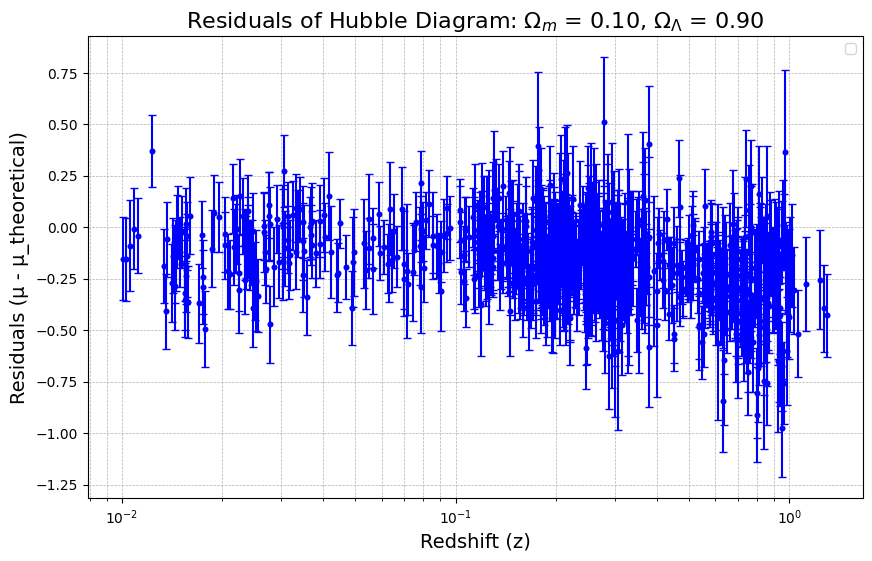

In [12]:
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad

# Constants
c = 3e5  # Speed of light in km/s
H_o = 70  # Hubble constant in km/s/Mpc

# Example values for Omega_m and Omega_Lambda
Omega_m_values = np.linspace(0.1, 0.5, 100)
Omega_Lambda_values = 1 - Omega_m_values

# Redshift values
zcmb = data['zcmb']

# Function to calculate luminosity distance
def integrand(z_prime, Omega_m):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + 1 - Omega_m)

def luminosity_distance(z, Omega_m):
    integral, _ = quad(integrand, 0, z, args=(Omega_m,))
    d_L = (c / H_o) * (1 + z) * integral
    return d_L

# Simulated data for mu and sigma_mu
mu = mb - MB + alpha * x1 - beta * color


# Initial theoretical values
d_L_vals = np.array([luminosity_distance(z, Omega_m_values[0]) for z in zcmb])
mu_theoretical = 5 * np.log10(d_L_vals * 1e6 / 10)  # H_o is in km/s/Mpc, d_L must convert to pc via 1e6

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xscale('log')
ax.set_xlabel('Redshift (z)', fontsize=14)
ax.set_ylabel('Residuals (μ - μ_theoretical)', fontsize=14)
ax.set_title('Residuals of Hubble Diagram for Varying Omega_m and Omega_Lambda', fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)

# Scatter plot with error bars
scatter = ax.scatter(zcmb, mu - mu_theoretical, c='blue', s=10)
errorbars = ax.errorbar(zcmb, mu - mu_theoretical, yerr=abs(sigma_mu), fmt='o', color='blue', capsize=3, capthick=1, markersize=3)
legend = ax.legend()

# Initialization function
def init():
    scatter.set_offsets(np.c_[zcmb, mu - mu_theoretical])
    return scatter,

# Animation function
def animate(i):
    Omega_m = Omega_m_values[i]
    Omega_Lambda = Omega_Lambda_values[i]
    
    # Recalculate theoretical distance modulus
    d_L_vals = np.array([luminosity_distance(z, Omega_m) for z in zcmb])
    mu_theoretical = 5 * np.log10(d_L_vals * 1e6 / 10)  # H_o is in km/s/Mpc, d_L must convert to pc via 1e6
    
    # Calculate residuals
    residuals = mu - mu_theoretical
    
    # Update scatter plot data
    scatter.set_offsets(np.c_[zcmb, residuals])
    ax.set_title(f'Residuals of Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}, $\Omega_\Lambda$ = {Omega_Lambda:.2f}', fontsize=16)
    return scatter

# Create animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(Omega_m_values), interval=100, blit=True)

# Save the animation as a GIF
ani.save('residuals_varying_omega.gif', writer='pillow')

plt.show()


<>:79: SyntaxWarning: invalid escape sequence '\O'
<>:79: SyntaxWarning: invalid escape sequence '\O'
/var/folders/71/hv72gkrs7g59ty6664549kjr0000gr/T/ipykernel_3751/1783457878.py:79: SyntaxWarning: invalid escape sequence '\O'
  ax.set_title(f'Residuals of Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}', fontsize=16)


AttributeError: 'ErrorbarContainer' object has no attribute 'set_offsets'

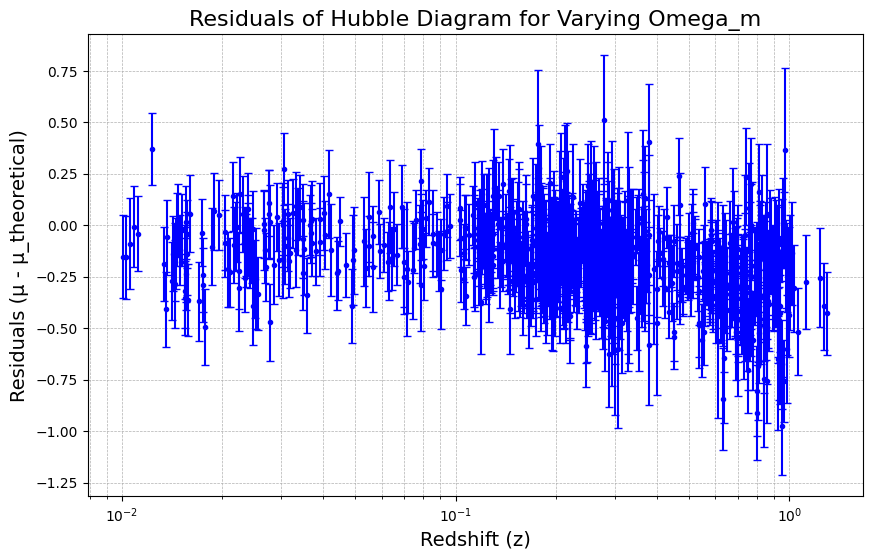

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.integrate import quad

# Constants
c = 3e5  # Speed of light in km/s
H_o = 70  # Hubble constant in km/s/Mpc

# Example values for Omega_m and Omega_Lambda
Omega_m_values = np.linspace(0.01, 1, 100)
Omega_Lambda_values = 1 - Omega_m_values

# Calculate distance modulus
mu = mb - MB + alpha * x1 - beta * color


# Redshift values
zcmb = data['zcmb']

# uncertainties and covariances given in jla_lcparams.txt
dm_b = data['dmb']          # Uncertainty in m_B*
dx1 = data['dx1']           # Uncertainty in x1
dcolor = data['dcolor']     # Uncertainty in color
cov_m_s = data['cov_m_s']   # Covariance between m_B* and x1
cov_m_c = data['cov_m_c']   # Covariance between m_B* and color
cov_s_c = data['cov_s_c']   # Covariance between x1 and color

# Calculate uncertainty in distance modulus
sigma_mu = np.sqrt(
    dm_b**2 +
    (alpha * dx1)**2 +
    (beta * dcolor)**2 +
    2 * alpha * cov_m_s +
    2 * beta * cov_m_c +
    2 * alpha * beta * cov_s_c
)

# Function to calculate luminosity distance
def integrand(z_prime, Omega_m):
    return 1.0 / np.sqrt(Omega_m * (1 + z_prime)**3 + 1 - Omega_m)

def luminosity_distance(z, Omega_m):
    integral, _ = quad(integrand, 0, z, args=(Omega_m,))
    d_L = (c / H_o) * (1 + z) * integral
    return d_L


# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlabel('Redshift (z)', fontsize=14)
ax.set_ylabel('Residuals (μ - μ_theoretical)', fontsize=14)
ax.set_title('Residuals of Hubble Diagram for Varying Omega_m', fontsize=16)
ax.grid(True, which="both", linestyle="--", linewidth=0.5)
ax.set_xscale('log')

# Scatter plot with error bars
errorbars = ax.errorbar(zcmb, mu-mu_theoretical, yerr=sigma_mu, fmt='o', color='blue', capsize=3, capthick=1, markersize=3)

# Initialization function
def init():
    errorbars.set_offsets(np.c_[zcmb, mu])
    return errorbars,

# Animation function
def animate(i):
    Omega_m = Omega_m_values[i]
    
    # Recalculate theoretical distance modulus
    d_L_real_res_vals = np.array([luminosity_distance(z, Omega_m) for z in zcmb])
    mu_theoretical = 5 * np.log10(d_L_real_res_vals * 1e6 / 10)  # H_o is in km/s/Mpc, d_L must convert to pc via 1e6
    
    # Calculate residuals
    residuals = mu - mu_theoretical
    
    # Update scatter plot data
    errorbars.set_offsets(np.c_[zcmb, residuals])

    ax.set_title(f'Residuals of Hubble Diagram: $\Omega_m$ = {Omega_m:.2f}', fontsize=16)
    return scatter, errorbars

# Create animation
ani = FuncAnimation(fig, animate, init_func=init, frames=len(Omega_m_values), interval=100, blit=True)

# Save the animation as a GIF
ani.save('residuals_varying_omega.gif', writer='pillow')

plt.show()